In [1]:
from pprint import pprint

import util

# <center>API REST : accéder à des données et des fonctionnalités via le web</center>

<br>
<center>Gabriel Couture, Félix-Antoine Fortin, Olivier Chouinard-Banville</center>

## Mise en situation

- Vous êtes un stagiaire en physique médiale
- Vous devez évaluer la qualité de traitements de radiothérapie
- Pour ce faire : nous utilisons les histogrammes dose-volume (DVH)

## Radiothérapie : cours express

- Acquisition d'images
- Tracé de structure (organes/région d'intérêt)
- Planification de la dose à délivrer
- Administraction de la dose
<center><img src="./imgs/radiotherapy.png" style="width: 700px;"></center>

## Radiothérapie : cours express
- Tracé de structure (organes/région d'intérêt)

<center><img src="./imgs/segmentation.png" style="width: 600px;"></center>

## Radiothérapie : cours express
- Administration de la dose

<center><img src="./imgs/dose.png" style="width: 600px;"></center>

## Radiothérapie : cours express
- Données impliquées
    - Images CT
    - Structure (région/organe dessiné)
    - Carte de dose (array en 3D de la dose délivrée)
<center><img src="./imgs/ct-struct-dose.gif" style="width: 100%;"></center>

## Comment évaluer la qualité du traitement?

- Histogramme dose-volume (DVH)


## À faire

<center><img src="./imgs/atelier.png" style="width: 1200px;"></center>

## Données à récupérer

<table border="0">
 <tr>
    <td><img src="./imgs/cylinder.png" style="width: 250px;"></td>
    <td><img src="./imgs/sphere.png" style="width: 250px;"></td>
 </tr>
</table>

## Librairie Python `requests`

- GET `requests.get(url='http://<url>', params={'key': 'value'})`
- POST `requests.post(url='http://<url>', data={'key': 'value'}, files={'key': file})`
- PUT `requests.put(url='http://<url>', data={'key': 'value'})`
- DELETE `requests.delete(url='http://<url>')`

In [2]:
import requests

URL = 'http://localhost:5000/'

## Valider la connexion

In [3]:
response = requests.get(f'{URL}')
print('Code HTTP:', response.status_code)
pprint(response.json())

Code HTTP: 200
{'message': 'Bonjour et bienvenue au workshop sur le Web!'}


## Création d'un compte
- Créez d'abord votre compte
- Pour créer un compte, faîtes un POST avec votre idul à la route `http://URL/account`
    - Vous pouvez soumettre votre idul de cette façon : `{'idul': 'votre-idul'}`

In [4]:
response = requests.post(f'{URL}/account', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

201
{'message': 'created'}


## Authentification

- Vous avez maintenant un compte, utilisez votre IDUL pour vous connecter!
- La route de l'API REST qui vous permet d'émettre un jeton d'authentification est `http://URL/auth`
- Soumettez votre idul via un POST afin d'émettre un jeton (token)
- Ce jeton vous permettra valider votre identiter par la suite

In [5]:
response = requests.post(f'{URL}/auth', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

200
{'token': 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'}


## Récupération des données
- Les données sont sous le format DICOM
- Vérifiez quelles données sont accessibles en les récupérant à `http://URL/data`
- Pour calculer un DVH, vous aurez besoin de r

In [6]:
TOKEN = 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'

response = requests.get(f'{URL}/data', params={'token': TOKEN})
print(response.json())

['sphere', 'cylinder', 'cone', 'dose']


In [7]:
response = requests.get(f'{URL}/data/sphere', params={'token': TOKEN})
sphere = util.read_dicom_dataset(response.content)
print(sphere.Modality)
print(sphere.PatientName)

response = requests.get(f'{URL}/data/cylinder', params={'token': TOKEN})
cylinder = util.read_dicom_dataset(response.content)
print(cylinder.Modality)
print(cylinder.PatientName)

response = requests.get(f'{URL}/data/cone', params={'token': TOKEN})
cone = util.read_dicom_dataset(response.content)
print(cone.Modality)
print(cone.PatientName)

response = requests.get(f'{URL}/data/dose', params={'token': TOKEN})
dose = util.read_dicom_dataset(response.content)
print(dose.Modality)
print(dose.PatientName)

RTSTRUCT
DVH_Phantom
RTSTRUCT
DVH_Phantom
RTSTRUCT
DVH_Phantom
RTDOSE
DVH_Phantom


In [8]:
sphere_bytes = util.dicom_dataset_to_bytes(sphere)
response = requests.post(f'{URL}/anonymize', files={'file': sphere_bytes})
sphere = util.read_dicom_dataset(response.content)
print(sphere.PatientName)

cylinder_bytes = util.dicom_dataset_to_bytes(cylinder)
response = requests.post(f'{URL}/anonymize', files={'file': cylinder_bytes})
cylinder = util.read_dicom_dataset(response.content)
print(cylinder.PatientName)

cone_bytes = util.dicom_dataset_to_bytes(cone)
response = requests.post(f'{URL}/anonymize', files={'file': cone_bytes})
cone = util.read_dicom_dataset(response.content)
print(cone.PatientName)

dose_bytes = util.dicom_dataset_to_bytes(dose)
response = requests.post(f'{URL}/anonymize', files={'file': dose_bytes})
dose = util.read_dicom_dataset(response.content)
print(dose.PatientName)

^
^
^
^


## Calcul des DVH

In [9]:
dvhs = {}

for name, struct in [('sphere', sphere), ('cylinder', cylinder), ('cone', cone)]:
    response = requests.post(
        f'{URL}/dvh',
        files={
            'file_struct': util.dicom_dataset_to_bytes(struct),
            'file_dose': util.dicom_dataset_to_bytes(dose)}
    )
    dvhs[name] = response.json()

200


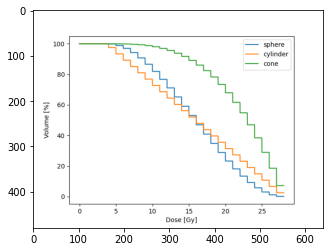

In [14]:
formated_dvhs = []
for name, dvh in dvhs.items():
    formated_dvhs.append({
        'name': name,
        'volumes': dvh[1]['volumes'],
        'doses': dvh[1]['doses'],
        'volume_units': dvh[1]['volume_units'],
        'dose_units': dvh[1]['dose_units']
    })
response = requests.post(
    f'{URL}/dvh/plot',
    json={'dvhs': formated_dvhs}
)
print(response.status_code)
util.show_image_from_bytes(response.content)